# Set-up

In [1]:
# Import packages
import os
import sys
import numpy as np
import pandas as pd
import scanpy as sc
import decoupler as dc
import snapatac2 as snap
import scipy.stats as stats

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [2]:
# File paths
sample_metadata_path = "/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/metadata/2023_11_26/sample_metadata_26Nov23.tsv"
h5ad_path = "/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/2024_01_21/condition_within_batch/ext4/cellcommander/rna/annotate/annotate.h5ad"
cellid_colors_path = "/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/ref/26Nov23/cellid_colors.tsv"
condition_colors_path = "/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/ref/26Nov23/condition_colors.tsv"
fig_dir = "/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/analysis/2024_01_21"

# Confirm they exist
assert os.path.exists(sample_metadata_path)
assert os.path.exists(h5ad_path)

# Make figure directory
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)

# Params
umap_key = "X_seurat_default_umap"
pca_key = "X_seurat_default"
cell_id_col = "integrated_manual_cellid_annotation"
num_pcs = 10

# Load and format data

In [3]:
# Load and inspect sample metadata
sample_metadata = pd.read_csv(sample_metadata_path, sep="\t")[['sample_id', 'sample_description', 'atac_library_id', 'rna_library_id','batch', 'timepoint', 'condition']]
sample_metadata.head()

,sample_id,sample_description,atac_library_id,rna_library_id,batch,timepoint,condition
0,dm0b,0hr_control,WB_73,WB_74,A2,0,control
1,dm11a,6hr_3-cyt,WB_7,WB_8,A2,6,3-cyt
2,dm12b,6hr_IFNg,WB_75,WB_76,A2,6,IFNg
3,dm14b,6hr_Ex-4_HG,WB_47,WB_48,A2,6,Ex-4_HG
4,dm21a,24hr_3-cyt,WB_11,WB_12,A2,24,3-cyt


In [4]:
# Load cell id colors
cellid_colors = pd.read_csv(cellid_colors_path, sep="\t", index_col=0, header=None)
cellid_colors = cellid_colors.to_dict()[1]
cellid_colors

{'SC.beta': '#2a9df4',
 'SC.alpha': '#967bb6',
 'SC.EC': '#ff7f50',
 'SC.delta': '#dc143c',
 'proliferating_alpha': '#ff91a4',
 'other': '#708090'}

In [5]:
# Load in condition colors
condition_colors = pd.read_csv(condition_colors_path, delim_whitespace=True, index_col=0, header=None)
condition_colors = condition_colors.to_dict()[1]
condition_colors

{'control': '#B0B0B0',
 '3-cyt': '#FFA07A',
 'IFNg': '#FF7F50',
 'Ex-4_HG': '#90EE90',
 'palmitate': '#BA55D3',
 'dex': '#ADD8E6'}

In [6]:
# Read in h5ad file
adata = sc.read_h5ad(h5ad_path)
bcs = adata.obs.index.tolist()
adata

AnnData object with n_obs × n_vars = 37214 × 36601
    obs: 'gex_barcode_cellranger', 'atac_barcode_cellranger', 'is_cell_cellranger', 'excluded_reason_cellranger', 'gex_raw_reads_cellranger', 'gex_mapped_reads_cellranger', 'gex_conf_intergenic_reads_cellranger', 'gex_conf_exonic_reads_cellranger', 'gex_conf_intronic_reads_cellranger', 'gex_conf_exonic_unique_reads_cellranger', 'gex_conf_exonic_antisense_reads_cellranger', 'gex_conf_exonic_dup_reads_cellranger', 'gex_exonic_umis_cellranger', 'gex_conf_intronic_unique_reads_cellranger', 'gex_conf_intronic_antisense_reads_cellranger', 'gex_conf_intronic_dup_reads_cellranger', 'gex_intronic_umis_cellranger', 'gex_conf_txomic_unique_reads_cellranger', 'gex_umis_count_cellranger', 'gex_genes_count_cellranger', 'atac_raw_reads_cellranger', 'atac_unmapped_reads_cellranger', 'atac_lowmapq_cellranger', 'atac_dup_reads_cellranger', 'atac_chimeric_reads_cellranger', 'atac_mitochondrial_reads_cellranger', 'atac_fragments_cellranger', 'atac_TSS_fra

In [7]:
# Merge metadata
adata_obs = adata.obs.merge(sample_metadata, left_on="sample", right_on="sample_id")
adata_obs.index = bcs
adata.obs = adata_obs
adata.obs.head()

,gex_barcode_cellranger,atac_barcode_cellranger,is_cell_cellranger,excluded_reason_cellranger,gex_raw_reads_cellranger,gex_mapped_reads_cellranger,gex_conf_intergenic_reads_cellranger,gex_conf_exonic_reads_cellranger,gex_conf_intronic_reads_cellranger,gex_conf_exonic_unique_reads_cellranger,...,leiden_1,sample,integrated_manual_cellid_annotation,sample_id,sample_description,atac_library_id,rna_library_id,batch,timepoint,condition
dm14b#AAACAGCCAATAATCC-1,AAACAGCCAATAATCC-1,ACAGCGGGTAGGTTCT-1,1,0,4174,3809,402,398,2020,342,...,5,dm14b,SC.alpha,dm14b,6hr_Ex-4_HG,WB_47,WB_48,A2,6,Ex-4_HG
dm14b#AAACAGCCACCTCAGG-1,AAACAGCCACCTCAGG-1,ACAGCGGGTGAGTTTC-1,1,0,42201,41089,2663,6693,30090,5854,...,4,dm14b,SC.beta,dm14b,6hr_Ex-4_HG,WB_47,WB_48,A2,6,Ex-4_HG
dm14b#AAACATGCATTTAAGC-1,AAACATGCATTTAAGC-1,CATTTAGGTTCACTTT-1,1,0,18047,17448,1325,4216,11182,3783,...,2,dm14b,SC.EC,dm14b,6hr_Ex-4_HG,WB_47,WB_48,A2,6,Ex-4_HG
dm14b#AAACCAACAAACAACA-1,AAACCAACAAACAACA-1,CTTTATCGTGTGTTAC-1,1,0,7132,6577,621,985,4030,907,...,4,dm14b,SC.beta,dm14b,6hr_Ex-4_HG,WB_47,WB_48,A2,6,Ex-4_HG
dm14b#AAACCAACAGGCTTGT-1,AAACCAACAGGCTTGT-1,CTTTATCGTTGCAAGA-1,0,1,15264,14640,1097,2504,10171,1985,...,0,dm14b,SC.EC,dm14b,6hr_Ex-4_HG,WB_47,WB_48,A2,6,Ex-4_HG


In [8]:
# Change variable names
adata.obsm["X_umap"] = adata.obsm[umap_key]
adata.obsm["X_pca"] = adata.obsm[pca_key]
adata.obs["cell_id"] = adata.obs[cell_id_col]
adata

AnnData object with n_obs × n_vars = 37214 × 36601
    obs: 'gex_barcode_cellranger', 'atac_barcode_cellranger', 'is_cell_cellranger', 'excluded_reason_cellranger', 'gex_raw_reads_cellranger', 'gex_mapped_reads_cellranger', 'gex_conf_intergenic_reads_cellranger', 'gex_conf_exonic_reads_cellranger', 'gex_conf_intronic_reads_cellranger', 'gex_conf_exonic_unique_reads_cellranger', 'gex_conf_exonic_antisense_reads_cellranger', 'gex_conf_exonic_dup_reads_cellranger', 'gex_exonic_umis_cellranger', 'gex_conf_intronic_unique_reads_cellranger', 'gex_conf_intronic_antisense_reads_cellranger', 'gex_conf_intronic_dup_reads_cellranger', 'gex_intronic_umis_cellranger', 'gex_conf_txomic_unique_reads_cellranger', 'gex_umis_count_cellranger', 'gex_genes_count_cellranger', 'atac_raw_reads_cellranger', 'atac_unmapped_reads_cellranger', 'atac_lowmapq_cellranger', 'atac_dup_reads_cellranger', 'atac_chimeric_reads_cellranger', 'atac_mitochondrial_reads_cellranger', 'atac_fragments_cellranger', 'atac_TSS_fra

In [9]:
# Merge PC values
pcs = pd.DataFrame(adata.obsm["X_pca"][:, :10], columns=[f"PC{i}" for i in range(1, 11)], index=adata.obs.index)
adata.obs = pd.concat([adata.obs, pcs], axis=1)
adata.obs.head()

,gex_barcode_cellranger,atac_barcode_cellranger,is_cell_cellranger,excluded_reason_cellranger,gex_raw_reads_cellranger,gex_mapped_reads_cellranger,gex_conf_intergenic_reads_cellranger,gex_conf_exonic_reads_cellranger,gex_conf_intronic_reads_cellranger,gex_conf_exonic_unique_reads_cellranger,...,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
dm14b#AAACAGCCAATAATCC-1,AAACAGCCAATAATCC-1,ACAGCGGGTAGGTTCT-1,1,0,4174,3809,402,398,2020,342,...,5.829669,1.473209,-5.163957,-2.672573,-3.256013,-1.394946,-1.553018,2.525079,0.344421,-0.946182
dm14b#AAACAGCCACCTCAGG-1,AAACAGCCACCTCAGG-1,ACAGCGGGTGAGTTTC-1,1,0,42201,41089,2663,6693,30090,5854,...,4.796324,1.912555,5.262275,5.776284,0.745722,-3.051838,-3.817973,6.845716,-0.602202,1.590752
dm14b#AAACATGCATTTAAGC-1,AAACATGCATTTAAGC-1,CATTTAGGTTCACTTT-1,1,0,18047,17448,1325,4216,11182,3783,...,0.098576,-1.120919,-7.868424,-1.340332,7.308606,-3.018480,-0.459740,5.818866,-1.623113,1.453081
dm14b#AAACCAACAAACAACA-1,AAACCAACAAACAACA-1,CTTTATCGTGTGTTAC-1,1,0,7132,6577,621,985,4030,907,...,3.635308,-0.148861,-11.234585,0.794567,-0.987821,-6.129379,-3.789197,-6.820825,1.192646,0.203681
dm14b#AAACCAACAGGCTTGT-1,AAACCAACAGGCTTGT-1,CTTTATCGTTGCAAGA-1,0,1,15264,14640,1097,2504,10171,1985,...,-3.219760,-1.098067,-0.004495,-2.737570,9.849167,-1.541676,1.826068,2.074095,2.078572,-0.124554


In [10]:
# Remove any colors that are not in the data
timepoint_categories = adata.obs["timepoint"].unique()
cellid_colors = {k: v for k, v in cellid_colors.items() if k in adata.obs["cell_id"].unique()}
condition_colors = {k: v for k, v in condition_colors.items() if k in adata.obs["condition"].unique()}

In [64]:
# Timepoint should be a categorical variable with a gradient of colors that increases from 0, 6, 24, 48, 72
adata.obs["timepoint"] = adata.obs["timepoint"].astype("category")
adata.obs["timepoint"] = adata.obs["timepoint"].cat.reorder_categories(timepoint_categories)
adata.uns["timepoint_colors"] = list(plt.get_cmap("Reds")(np.linspace(0, 1, len(timepoint_categories))))

# Cell id should be a categorical variable 
adata.obs["cell_id"] = adata.obs["cell_id"].astype("category")
adata.obs["cell_id"] = adata.obs["cell_id"].cat.reorder_categories(cellid_colors.keys())
adata.uns["cell_id_colors"] = list(cellid_colors.values())

# Condition should be a categorical variable
adata.obs["condition"] = adata.obs["condition"].astype("category")
adata.obs["condition"] = adata.obs["condition"].cat.reorder_categories(condition_colors.keys())
adata.uns["condition_colors"] = list(condition_colors.values())

# Make dtype float
adata.obs[["pct_counts_mt", "log1p_total_counts", "scrublet_doublet_score"]] = adata.obs[["pct_counts_mt", "log1p_total_counts", "scrublet_doublet_score"]].astype(float)

# DEG analysis at single cell level

In [32]:
sc.tl.rank_genes_groups(
    adata, 
    layer="log1p_norm",
    use_raw=False,
    groupby='condition',
    groups=['control', 'Ex-4_HG'],
    reference='control',
    method='t-test', 
    key_added = "t-test"
)

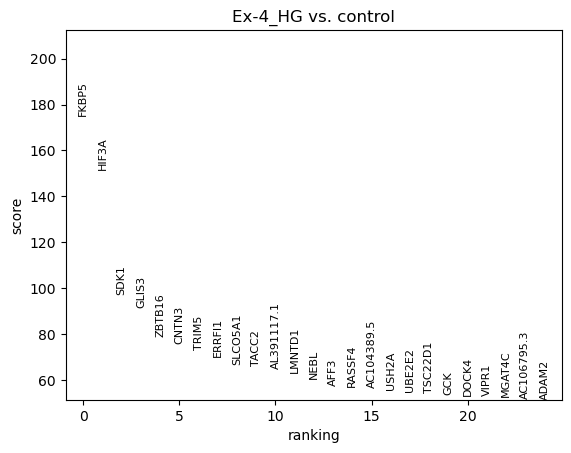

In [33]:
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, key = "t-test")

In [34]:
sc.tl.rank_genes_groups(
    adata, 
    layer="log1p_norm",
    use_raw=False,
    groupby='condition',
    groups=['control', 'Ex-4_HG'],
    reference='control',
    method='t-test_overestim_var',
    key_added = "t-test_overestim_var"
)

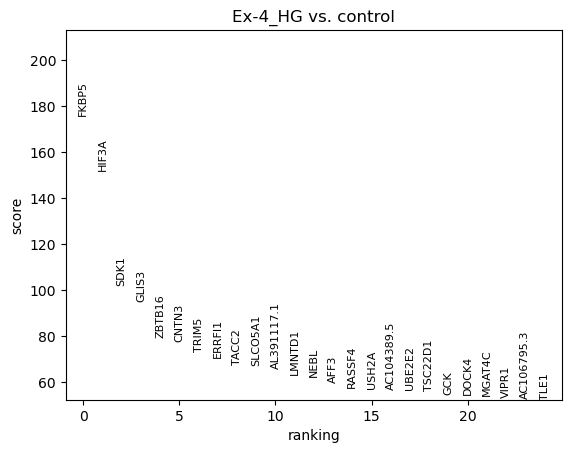

In [35]:
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, key = "t-test_overestim_var")

In [36]:
sc.tl.rank_genes_groups(
    adata, 
    layer="log1p_norm",
    use_raw=False,
    groupby='condition',
    groups=['control', 'Ex-4_HG'],
    reference='control',
    method='wilcoxon',
    key_added = "wilcoxon"
)

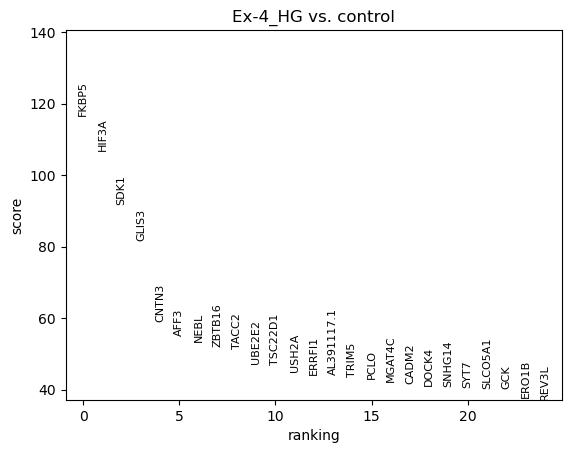

In [37]:
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, key = "wilcoxon")

In [53]:
sc.tl.rank_genes_groups(
    adata, 
    layer="log1p_norm",
    use_raw=False,
    groupby='condition',
    groups=['control', 'Ex-4_HG'],
    reference='Ex-4_HG',
    method='logreg',
    key_added = "logreg"
)

/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


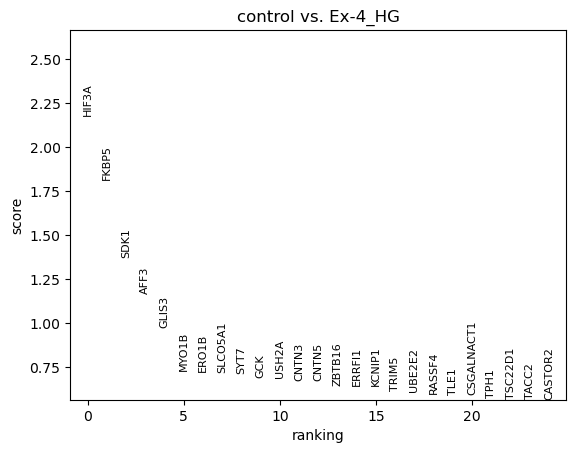

In [54]:
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, key = "logreg")

In [55]:
adata.uns['wilcoxon']['names']['Ex-4_HG']

array(['FKBP5', 'HIF3A', 'SDK1', ..., 'RGS7', 'KCNB2', 'CADPS'],
      dtype=object)

In [56]:
adata.uns['logreg']['names']

rec.array([('HIF3A',), ('FKBP5',), ('SDK1',), ..., ('CADPS',), ('PLD5',),
           ('PTH2R',)],
          dtype=[('control', 'O')])

/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/matplotlib_venn/_venn3.py:117: UserWarning: Bad circle positioning
  warnings.warn("Bad circle positioning")


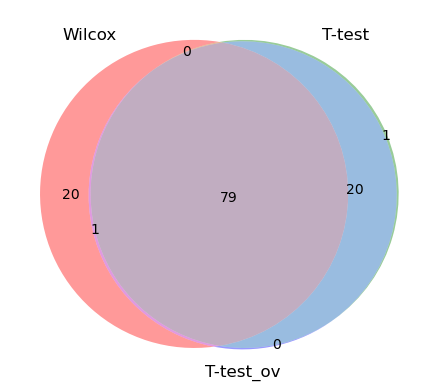

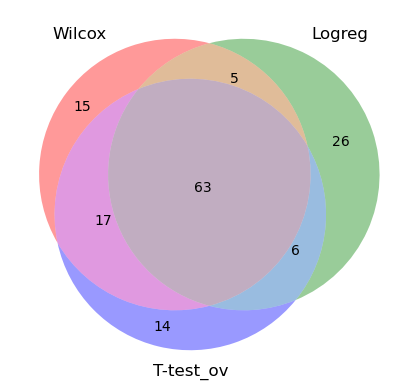

In [58]:
#compare cluster1 genes, only stores top 100 by default
wc = adata.uns['wilcoxon']['names']['Ex-4_HG'][0:100]
tt = adata.uns['t-test']['names']['Ex-4_HG'][0:100]
tt_ov = adata.uns['t-test_overestim_var']['names']['Ex-4_HG'][0:100]
lr = adata.uns['logreg']['names']['control'][0:100]

from matplotlib_venn import venn3

venn3([set(wc),set(tt),set(tt_ov)], ('Wilcox','T-test','T-test_ov') )
plt.show()


venn3([set(wc),set(lr),set(tt_ov)], ('Wilcox','Logreg','T-test_ov') )

In [62]:
adata.uns["wilcoxon"]

{'params': {'groupby': 'condition',
  'reference': 'control',
  'method': 'wilcoxon',
  'use_raw': False,
  'layer': 'log1p_norm',
  'corr_method': 'benjamini-hochberg'},
 'names': rec.array([('FKBP5',), ('HIF3A',), ('SDK1',), ..., ('RGS7',), ('KCNB2',),
            ('CADPS',)],
           dtype=[('Ex-4_HG', 'O')]),
 'scores': rec.array([(116.69621 ,), (106.75876 ,), ( 91.595436,), ...,
            (-47.99404 ,), (-51.289566,), (-64.1495  ,)],
           dtype=[('Ex-4_HG', '<f4')]),
 'pvals': rec.array([(0.,), (0.,), (0.,), ..., (0.,), (0.,), (0.,)],
           dtype=[('Ex-4_HG', '<f8')]),
 'pvals_adj': rec.array([(0.,), (0.,), (0.,), ..., (0.,), (0.,), (0.,)],
           dtype=[('Ex-4_HG', '<f8')]),
 'logfoldchanges': rec.array([( 5.448372  ,), ( 5.674206  ,), ( 1.4142723 ,), ...,
            (-0.6497012 ,), (-0.90387493,), (-0.7946951 ,)],
           dtype=[('Ex-4_HG', '<f4')])}

In [63]:
adata.uns["condition_colors"]

dict_values(['#B0B0B0', '#90EE90'])

In [68]:
adata.X = adata.layers["log1p_norm"]

In [70]:
adata.raw = adata

In [71]:
sc.pl.rank_genes_groups_heatmap?

Signature:
sc.pl.rank_genes_groups_heatmap(
    adata: anndata._core.anndata.AnnData,
    groups: Union[str, Sequence[str]] = None,
    n_genes: Optional[int] = None,
    groupby: Optional[str] = None,
    gene_symbols: Optional[str] = None,
    var_names: Union[Sequence[str], Mapping[str, Sequence[str]], NoneType] = None,
    min_logfoldchange: Optional[float] = None,
    key: str = None,
    show: Optional[bool] = None,
    save: Optional[bool] = None,
    **kwds,
)
Docstring:
Plot ranking of genes using heatmap plot (see :func:`~scanpy.pl.heatmap`)

Parameters
----------
adata
    Annotated data matrix.
groups
    The groups for which to show the gene ranking.
n_genes
    Number of genes to show. This can be a negative number to show for
    example the down regulated genes. eg: num_genes=-10. Is ignored if
    `gene_names` is passed.
gene_symbols
    Column name in `.var` DataFrame that stores gene symbols. By default `var_names`
    refer to the index column of the `.var` DataFram

categories: control, Ex-4_HG
var_group_labels: Ex-4_HG


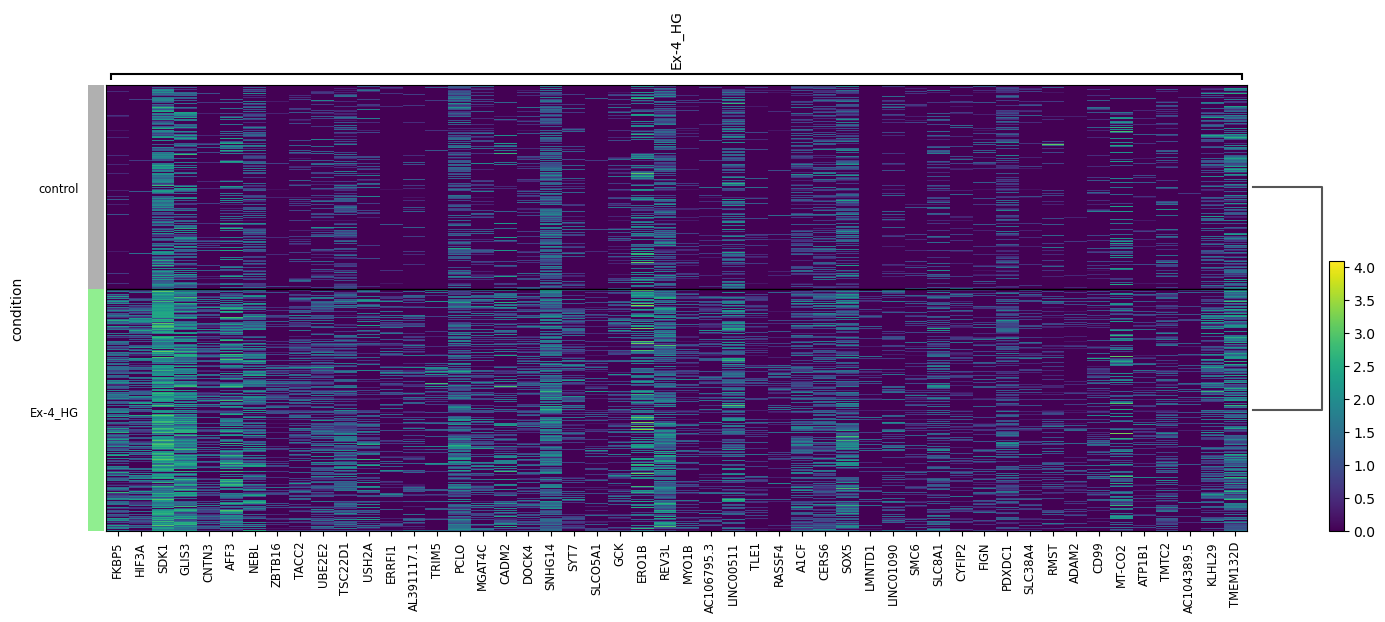

In [72]:
sc.pl.rank_genes_groups_heatmap(adata, n_genes=50, key="wilcoxon", groupby="condition", show_gene_labels=True)

/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


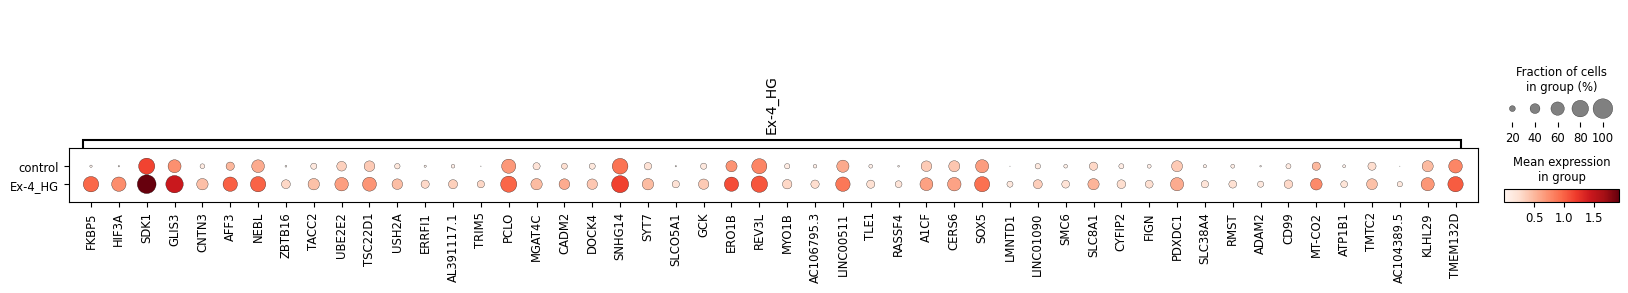

In [75]:
sc.pl.rank_genes_groups_dotplot(adata, n_genes=50, key="wilcoxon", groupby="condition")

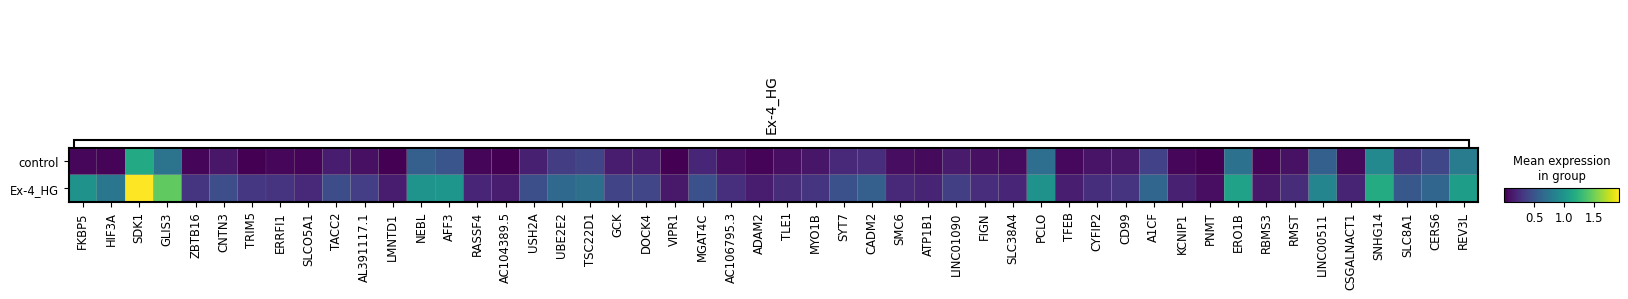

Error in atexit._run_exitfuncs:
Traceback (most recent call last):
  File "/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/IPython/core/history.py", line 844, in writeout_cache
    self._writeout_input_cache(conn)
  File "/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/IPython/core/history.py", line 827, in _writeout_input_cache
    conn.execute("INSERT INTO history VALUES (?, ?, ?, ?)",
sqlite3.DatabaseError: database disk image is malformed


In [78]:
sc.pl.rank_genes_groups_matrixplot(adata, n_genes=50, key="t-test", groupby="condition")